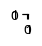

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, PairedVAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [4]:
pos_df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')

In [14]:
# This is the swapped dataset
b = pd.read_csv('../data/NetTCR/nettcr_train_mathias_with_swaps.csv')
b.to_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv', index=False)

In [2]:
def encode_cat(sequence, max_len):
    return F.pad(torch.tensor([CHAR_TO_INT[x] for x in sequence]), (0, max_len-(len(sequence))), value=-1)

def batch_encode_cat(sequences, max_len):
    return torch.stack([encode_cat(x, max_len) for x in sequences])

In [4]:
from src.data_processing import encode_batch, CHAR_TO_INT
from src.models import FullTCRVAE
from src.datasets import TCRpMHCDataset, TCRSpecificDataset
df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')
model = FullTCRVAE(0, 0, 22, 0, 0, 23, 'BL50LO', hidden_dim=128, latent_dim=64)
model = load_checkpoint(model, '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs.pt')
model.eval()
df['set'] = df['partition'].apply(lambda x: 'valid' if x==0 else 'train')

dataset = TCRSpecificDataset(df, 0, 0, 22, 0, 0, 23, 'BL50LO', 
                              -20,'A1', 'A2', 'A3', 'B1', 'B2', 'B3')

with torch.no_grad():
    z_embed = model.embed(dataset.x)
encoded_peps = batch_encode_cat(df['peptide'], 12)

Reloading best model:
Best epoch: 24959
total: 0.2867068297915406
reconstruction: 0.2530093719624275
kld: 0.006973478481103337
triplet: 0.02672399799200579
seq_accuracy: 0.9099540710449219
v_accuracy: 0
j_accuracy: 0


In [5]:
z=torch.normal(torch.tensor([-0.05]*10), torch.tensor([2]*10))
F.sigmoid(z), z

(tensor([0.7376, 0.8379, 0.4941, 0.4256, 0.0361, 0.0307, 0.0446, 0.1592, 0.2854,
         0.4761]),
 tensor([ 1.0333,  1.6430, -0.0234, -0.2998, -3.2851, -3.4526, -3.0650, -1.6641,
         -0.9176, -0.0956]))

In [8]:
from src.torch_utils import load_model_full
ckpt = '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs.pt'
js = '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs_JSON_kwargs.json'
model = load_model_full(ckpt, js)


Reloading best model:
Best epoch: 24959
total: 0.2867068297915406
reconstruction: 0.2530093719624275
kld: 0.006973478481103337
triplet: 0.02672399799200579
seq_accuracy: 0.9099540710449219
v_accuracy: 0
j_accuracy: 0


In [13]:
args = {'folder': '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/'}
checkpoint_file = next(filter(lambda x: x.startswith('checkpoint') and x.endswith('.pt'), os.listdir(args['folder'])))
json_file = next(filter(lambda x: x.startswith('checkpoint') and x.endswith('.json'), os.listdir(args['folder'])))

In [15]:
checkpoint_file,  json_file

('checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs.pt',
 'checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs_JSON_kwargs.json')

In [11]:
n_layers=1
for _ in range(n_layers-1):
    print('xd')

In [9]:
model

FullTCRVAE(
  (encoder): Sequential(
    (0): Linear(in_features=900, out_features=450, bias=True)
    (1): SELU()
    (2): Linear(in_features=450, out_features=128, bias=True)
    (3): SELU()
  )
  (encoder_mu): Linear(in_features=128, out_features=64, bias=True)
  (encoder_logvar): Linear(in_features=128, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): SELU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): SELU()
  )
  (decoder_sequence): Sequential(
    (0): Linear(in_features=128, out_features=450, bias=True)
    (1): SELU()
    (2): Linear(in_features=450, out_features=900, bias=True)
  )
)